In [1]:
import sys
from typing import Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange

from PyTorch_VAE import models
from diffusion_policy.common.pytorch_util import compute_conv_output_shape
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset

In [2]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# path = "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"

dataset = PushTImageDataset(path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)

In [3]:
def normalize(data):
    data /= 255.0
    data = 2 * data - 1
    return data


def unnormalize(data):
    data = (data + 1) / 2
    data *= 255
    return data

In [6]:
class VanillaVAE(models.VanillaVAE):

    def __init__(
        self,
        in_channels: int,
        in_height: int,
        in_width: int,
        latent_dim: int,
        hidden_dims: Optional[list] = None,
        **kwargs
    ) -> None:
        models.BaseVAE.__init__(self)

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        kernel_size = 3
        stride = 2
        padding = 1
        dilation = 1
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self.conv_out_shape = compute_conv_output_shape(
            H=in_height,
            W=in_width,
            padding=padding,
            stride=stride,
            kernel_size=kernel_size,
            dilation=dilation,
            num_layers=len(hidden_dims),
            last_hidden_dim=hidden_dims[-1],
        )
        conv_out_size = np.prod(self.conv_out_shape)

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(conv_out_size, latent_dim)
        self.fc_var = nn.Linear(conv_out_size, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, conv_out_size)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, *self.conv_out_shape)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

In [ ]:
full_dataset = normalize(full_dataset)
N, C, H, W = full_dataset.shape
train_split = 0.8
train_size = int(train_split * N)
val_size = N - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaVAE(in_channels=3, in_height=H, in_width=W, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 20

for epoch in trange(epochs):
    total_train_loss = 0
    model.train()
    for i, x in enumerate(train_loader):
        x = x.to(device)
        result = model(x)
        loss = model.loss_function(*result, M_N=1e-6)["loss"]
        # loss = loss['loss']
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Train loss:")
    print(total_train_loss / len(train_loader))

    total_val_loss = 0
    model.eval()
    with torch.no_grad():
        for i, x in enumerate(val_loader):
            x = x.to(device)
            result = model(x)
            loss = model.loss_function(*result, M_N=1e-6)["loss"]
            total_val_loss += loss.item()
    print("Validation loss:")
    print(total_val_loss / len(val_loader))

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss:
0.019861813929842966


  5%|▌         | 1/20 [00:07<02:14,  7.10s/it]

Validation loss:
0.006587538156681549
Train loss:
0.0052641347192831315


 10%|█         | 2/20 [00:13<02:01,  6.73s/it]

Validation loss:
0.004560660570859909
Train loss:
0.004212650190095919


 15%|█▌        | 3/20 [00:19<01:48,  6.39s/it]

Validation loss:
0.003990968563507155
Train loss:
0.003720280864838847


 20%|██        | 4/20 [00:25<01:37,  6.09s/it]

Validation loss:
0.003615619713058753
Train loss:
0.0033637172041310003


 25%|██▌       | 5/20 [00:30<01:27,  5.85s/it]

Validation loss:
0.003287391071873052
Train loss:
0.003073470097258571


 30%|███       | 6/20 [00:36<01:20,  5.76s/it]

Validation loss:
0.0030369303197894963
Train loss:
0.002815821856866675


 35%|███▌      | 7/20 [00:41<01:14,  5.72s/it]

Validation loss:
0.002819980679785613
Train loss:
0.002612758512721858


 40%|████      | 8/20 [00:47<01:08,  5.68s/it]

Validation loss:
0.0026976182385816338
Train loss:
0.0024463581430836


 45%|████▌     | 9/20 [00:53<01:02,  5.69s/it]

Validation loss:
0.0025701025769878064
Train loss:
0.002302282188099307


 50%|█████     | 10/20 [00:58<00:57,  5.71s/it]

Validation loss:
0.002458148761016103
Train loss:
0.0021851521394813194


 55%|█████▌    | 11/20 [01:04<00:52,  5.81s/it]

Validation loss:
0.0023234296533689827
Train loss:
0.002072816425238118


 60%|██████    | 12/20 [01:10<00:46,  5.79s/it]

Validation loss:
0.0021986584012795773
Train loss:
0.001966394845801014


 65%|██████▌   | 13/20 [01:16<00:40,  5.79s/it]

Validation loss:
0.0022018085760266886
Train loss:
0.001889943675975086


 70%|███████   | 14/20 [01:22<00:35,  5.95s/it]

Validation loss:
0.0020857841826350605
Train loss:
0.0018062016031287053


 75%|███████▌  | 15/20 [01:28<00:29,  5.90s/it]

Validation loss:
0.0019792447087892927
Train loss:
0.001740319232566636


 80%|████████  | 16/20 [01:34<00:23,  5.96s/it]

Validation loss:
0.0019324810688112
Train loss:
0.0016754267073955933


 85%|████████▌ | 17/20 [01:40<00:17,  5.91s/it]

Validation loss:
0.0019002203353802147
Train loss:
0.0016167321885396317


 90%|█████████ | 18/20 [01:46<00:11,  6.00s/it]

Validation loss:
0.0018762723045273226
Train loss:
0.0015644563102334551


 95%|█████████▌| 19/20 [01:52<00:05,  5.90s/it]

Validation loss:
0.0017897912311246214
Train loss:
0.0015087928191390226


100%|██████████| 20/20 [01:57<00:00,  5.90s/it]

Validation loss:
0.0017557391905520829


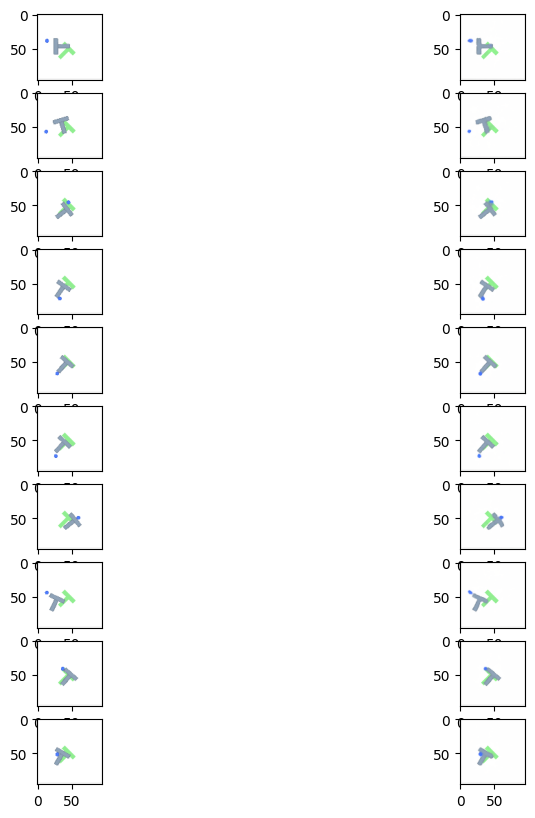

In [10]:
val_data = next(iter(val_loader))
num_samples = 10
val_data = val_data.to(device)
result = model(val_data)
recon = result[0]
recon = unnormalize(recon)
val_data = unnormalize(val_data)


fig, ax = plt.subplots(num_samples, 2)
fig.set_size_inches(10, 10)
for i in range(num_samples):
    ax[i, 0].imshow(
        val_data[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
    )
    ax[i, 1].imshow(recon[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
plt.show()